In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import Table
import matplotlib.pyplot as pl
import matplotlib.colors as mc
from scipy.interpolate import NearestNDInterpolator
from numpy import linspace, array, logspace, sin, cos, pi, arange, sqrt, arctan2, arccos
from mpl_toolkits.mplot3d import Axes3D
from coords import *
plt.style.use('classic')
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.weight"] = "bold"
plt.rcParams["font.size"] = "16"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"

def rotate(x,y,theta):
    xprime = x*cos(theta) - y*sin(theta)
    yprime = x*sin(theta) + y*cos(theta)
    return xprime, yprime

l_offset = np.radians(-0.0558)
b_offset = np.radians(-0.0462)
x_offset = Rsun*l_offset
y_offset = Rsun*b_offset

#############################
# create class that stores a ring
#############################

class Ring:

    def __init__(self,t,a,b,z,v0,theta,xyzsun,vxyzsun,alpha=0.4):
        self.t     = t
        self.a     = a
        self.b     = b
        self.z0    = z
        self.v0    = v0
        self.theta = theta
        self.x     = a*cos(t)
        self.y     = -b*sin(t)
        self.z     = self.z0*sin(-2*t + alpha)
        self.R     = sqrt(self.x**2+self.y**2)
        self.phi   = -arctan2(self.y,self.x)
        self.ephix = -sin(self.phi) # unit vector parallel to circle
        self.ephiy = -cos(self.phi) # unit vector parallel to circle
        norm       = sqrt((a*sin(t))**2+(b*cos(t))**2)
        self.ex    = -a*sin(t)/norm # unit vector parellel to ellipse
        self.ey    = -b*cos(t)/norm  # unit vector parallel to ellipse
        self.cosalpha = self.ex*self.ephix + self.ey*self.ephiy
        self.vphi  = self.R[0]*self.v0/self.R # assume conservation of angular momentum
        self.v     = self.vphi/self.cosalpha # total speed along the orbit
        self.vx    = +self.v*self.ex
        self.vy    = +self.v*self.ey
        self.vz    = np.zeros(t.size)
        self.x,self.y   = rotate(self.x,self.y,theta)
        self.vx,self.vy = rotate(self.vx,self.vy,theta)
        self.X,self.Y,self.Z,self.vX,self.Vy,self.vZ = xyz2XYZ(self.x,self.y,self.z,self.vx,self.vy,self.vz,xyzsun[0],xyzsun[1],xyzsun[2],vxyzsun[0],vxyzsun[1],vxyzsun[2])
        # Convert Sgr A* offset from degrees to radians
        l_offset = np.radians(0.05)
        b_offset = np.radians(-0.0462)
        x_offset = Rsun*l_offset
        y_offset = 0
        z_offset = Rsun*b_offset
        # Calculate galactic coordinates accounting for Sgr A* offset
        self.l,self.b,self.r,self.vl,self.vb,self.vr = xyz2lbr(
            self.x,self.y,self.z,self.vx,self.vy,self.vz,
            xyzsun[0],xyzsun[1],xyzsun[2],vxyzsun[0],vxyzsun[1],vxyzsun[2])
        self.l += l_offset
        self.b += b_offset
        self.x += x_offset
        self.y += y_offset
        self.z += z_offset
        self.mu_l, self.mu_b = vlb_2_mulb(self.r, self.vl*100, self.vb*100)
        self.mu_l, self.mu_b = vlb_2_mulb(self.r,self.vl*100,self.vb*100)


#############################
# define sun position & velocity
#############################

xsun  = 0.0
ysun  = -8.1
zsun  = 0.0
vxsun = -2.2
vysun = 0.0
vzsun = 0.0
xyzsun  = [xsun, ysun, zsun ]
vxyzsun = [vxsun,vysun,vzsun]
phisun  = arctan2(ysun,xsun)

#############################
# define rings
#############################

a_rings = 0.09 # x axis of the rings in kpc
b_rings = 0.055 # y axis of the rings in kpc
z_rings = 0.0125 # height of the ring above/below plane in kpc
v_rings = 130.0 # tangential velocity at initial point
theta_rings = np.radians(25) # inclination of the rings
dphi = np.radians(1)
phi  = arange(phisun+dphi/2,phisun+2*pi,dphi)
Rings = Ring(phi,a_rings,b_rings,z_rings,v_rings,theta_rings,xyzsun,vxyzsun)

back_ind = np.where(Rings.y>=y_offset)
fore_ind = np.where(Rings.y<=y_offset)




scouse_fits = pd.read_csv('final_cmz_scouse_hnco_fits.csv',
              usecols=[0,1,2,3,5,7], names=['n', 'l', 'b', 'amp', 'velocity', 'FWHM'],
              sep="\s+")

cat = Table.read('CMZ_cloud_catalogue_data.tex')

absorp_tab = Table.read('absorption_comparison_table_Oct22.tex')
absorp_value = absorp_tab['fraction_value']
absorp_13co = absorp_tab['co_h2co_ratio']
absorp_index = absorp_tab['leaf_id']

flux_frac_tab = Table.read('../paper_figs/Tables/CMZ_cat_flux_method_vals.tex')
flux_frac_value = flux_frac_tab['Extinction Fraction']
flux_frac_index = flux_frac_tab['leaf id']
flux_diff = flux_frac_tab['Flux Difference']
#flux_diff = cat['flux_diff_max']
flux_ratio_fore = flux_frac_tab['Flux Ratio']
min_flux = flux_frac_tab['Min Flux'] #Min flux from RAW spitzer image


divnorm = mc.TwoSlopeNorm(vmin=flux_diff.min(), vcenter=np.median(flux_diff), vmax=flux_diff.max())

l   = scouse_fits['l'].values
b   = scouse_fits['b'].values
v   = scouse_fits['velocity'].values
amp = scouse_fits['amp'].values

In [3]:
cat[20]

<Row index=20>
index  cloud_name    l       b      v   sigma   rad   absorp r_p_mom0 r_s_mom0 r_p_max r_s_max flux_diff_mom0 flux_ratio_mom0 I_cloud_max I_model_max flux_diff_max flux_ratio_max ext_frac_max lb_pixel_mask NF_decision min_flux_max
 str3    str14    float64 float64 int64 int64 float64 int64  float64  float64  float64 float64    float64         float64       float64     float64      float64       float64       float64        int64         str3      float64   
----- ----------- ------- ------- ----- ----- ------- ------ -------- -------- ------- ------- -------------- --------------- ----------- ----------- ------------- -------------- ------------ ------------- ----------- ------------
   14 G0.105-0.08   0.105   -0.08    53     9     1.7      1    0.502    0.486   0.502   0.486         38.645           0.484     205.483     316.898        38.645          0.484        0.946             1           N      146.993

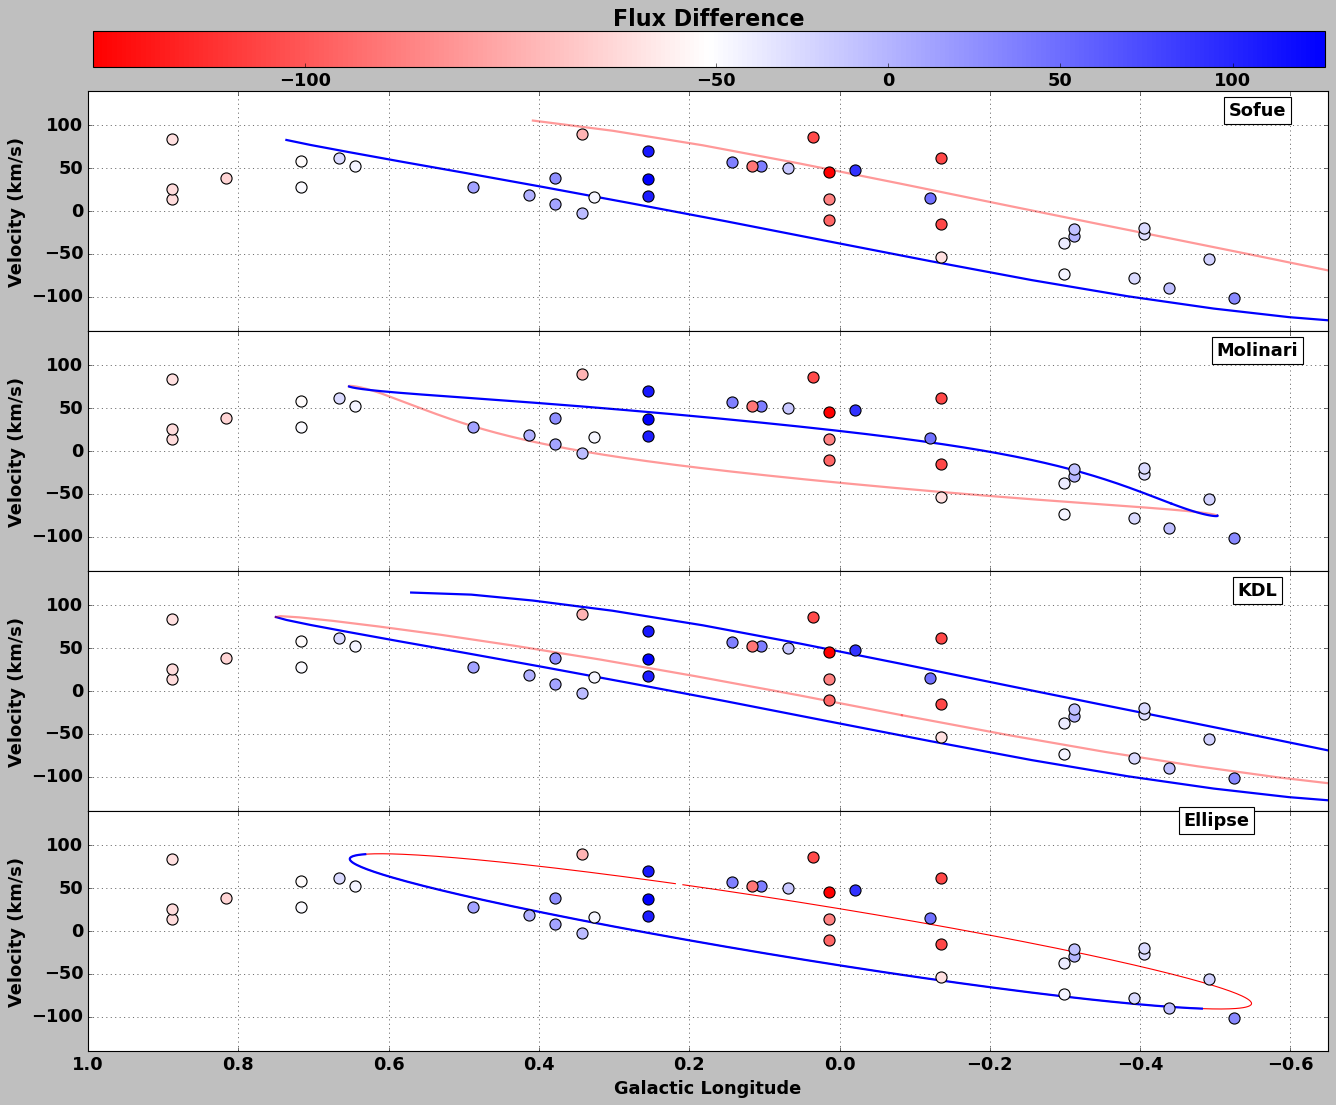

<Figure size 640x480 with 0 Axes>

In [4]:
####SINGLE COLUMN DUST EXTINCTION (RESIZED)####
#####FLUX DIFFERENCE######

divnorm = mc.TwoSlopeNorm(vmin=np.nanmin(cat['flux_diff_max']), vcenter=-52.09, vmax=np.nanmax(cat['flux_diff_max']))

l   = scouse_fits['l'].values
b   = scouse_fits['b'].values
v   = scouse_fits['velocity'].values
amp = scouse_fits['amp'].values



fig, ax = plt.subplots(nrows=4, ncols=1,  figsize=(20,15))
plt.subplots_adjust(wspace=0, hspace=0)


for row in ax:
    #row.scatter(l, v, c=amp, cmap='Blues', marker='o', s=1, facecolor='1', norm=mpl.colors.LogNorm(), alpha=0.2, zorder=1)
    for i in range(0,len(cat)):
            sc = row.scatter(cat['l'][i], cat['v'][i], marker='o', s=100, edgecolor='k', zorder=3, c=cat['flux_diff_max'][i], cmap='bwr_r', norm=divnorm)
   

    row.grid(True)
    row.set_xlim(1,-0.65)
    row.set_ylim(-140,140)
    row.set_rasterized(True)



"""
#Sofue
"""
sofue1 = np.loadtxt('sofue_lbv_arm1.txt', unpack=True)
sofue1_l, sofue1_b, sofue1_v = sofue1[0], sofue1[1], sofue1[2]
ax[0].plot(sofue1_l, sofue1_v, ls='-', color='blue', linewidth=2, zorder=2)

sofue2 = np.loadtxt('sofue_lbv_arm2.txt', unpack=True)
sofue2_l, sofue2_b, sofue2_v = sofue2[0], sofue2[1], sofue2[2]
ax[0].plot(sofue2_l, sofue2_v, ls='-', color='red', linewidth=2, zorder=2, alpha=0.4)
ax[0].xaxis.set_ticklabels([])
#ax[0].yaxis.set_ticklabels([-.30," " , -0.20," " , -.10," " , 0.00," " , " "])
ax[0].text(0.943, 0.92,'Sofue', ha='center', va='center', transform=ax[0].transAxes,
           bbox=dict(facecolor='white', edgecolor='k', alpha=1))
ax[0].set_ylabel('Velocity (km/s)')

"""


#Molinari
"""
ml = np.loadtxt('molinari_lbvlos.txt', unpack=True)
lk, bk, vk = ml[0], ml[1], ml[2]
ax[1].plot(-1*lk[80:580], vk[80:580], ls='-', color='red', linewidth=2, zorder=2, alpha=0.4)
ax[1].plot(-1*lk[0:80], vk[0:80], ls='-', color='blue', linewidth=2, zorder=2)
ax[1].plot(-1*lk[581:], vk[581:], ls='-', color='blue', linewidth=2, zorder=2)
ax[1].text(0.943, 0.92,'Molinari', ha='center', va='center', transform=ax[1].transAxes,
           bbox=dict(facecolor='white', edgecolor='k', alpha=1))

ax[1].xaxis.set_ticklabels([])
#ax[1].yaxis.set_ticklabels([-.30," " , -0.20," " , -.10," " , 0.00," " , " "])
ax[1].set_ylabel('Velocity (km/s)')



"""
#KDL
"""
kdl = np.loadtxt('kdl_lbv.txt', unpack=True)
lk, bk, vk = kdl[0], kdl[1], kdl[2]
ax[2].plot(lk[0:16], vk[0:16], ls='-', color='blue', linewidth=2, zorder=2)
ax[2].plot(lk[15:26], vk[15:26], ls='-', color='red', linewidth=2, zorder=2, alpha=0.4)
ax[2].plot(lk[25:36], vk[25:36], ls='-', color='red', linewidth=2, zorder=2, alpha=0.4)
ax[2].plot(lk[35:51], vk[35:51], ls='-', color='blue', linewidth=2, zorder=2)
ax[2].xaxis.set_ticklabels([])
#ax[2].yaxis.set_ticklabels([-.30," " , -0.20," " , -.10," " , 0.00," " , " "])

ax[2].text(0.943, 0.92,'KDL', ha='center', va='center', transform=ax[2].transAxes,
           bbox=dict(facecolor='white', edgecolor='k', alpha=1))

ax[2].set_ylabel('Velocity (km/s)')


"""
#Rings
"""


ax[3].plot(np.degrees(Rings.l[back_ind[0:-1]]),Rings.vr[back_ind[0:-1]],c='red')
ax[3].plot(np.degrees(Rings.l[fore_ind[0:]]),Rings.vr[fore_ind[0:]],c='blue', linewidth=2, zorder=2)

#ax[3].xaxis.set_ticklabels([])
#ax[3].yaxis.set_ticklabels([])
ax[3].text(0.91, 0.96,'Ellipse', ha='center', va='center', transform=ax[3].transAxes,
           bbox=dict(facecolor='white', edgecolor='k', alpha=1))

ax[3].set_ylabel('Velocity (km/s)')
ax[3].set_xlabel('Galactic Longitude')



cax = fig.add_axes([0.128, .92, 0.77, 0.03])
cb = plt.colorbar(sc, ax=ax.ravel().tolist(), orientation='horizontal', cax=cax)
cb.ax.set_title('Flux Difference', size=20, fontweight='bold', fontname='sans-serif')

plt.savefig('onecol_3d_models_lv_ellipse_colorbar_flux_diff_updated.png')
plt.show()


plt.clf()

# COMBINED LV SUBPLOT

np.isnan(r_p_mom0)


for i in range(0,len(cat)):
    if np.isnan(r_p_mom0[i]) == True:
        print('nan!')
    else:
        print(r_p_mom0[i])

/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_18743/445297597.py:67: UserWarning: FixedFormatter should only be used together with FixedLocator
  j.yaxis.set_ticklabels([" ", -100,-50,0,50,100, " "],fontsize=20)
/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_18743/445297597.py:174: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, fontsize=20, rotation=-30)
/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_18743/445297597.py:180: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels([r'',r'359.4$^{\circ}$',r'359.6$^{\circ}$',r'359.8$^{\circ}$',r'0.0$^{\circ}$',r'0.2$^{\circ}$',


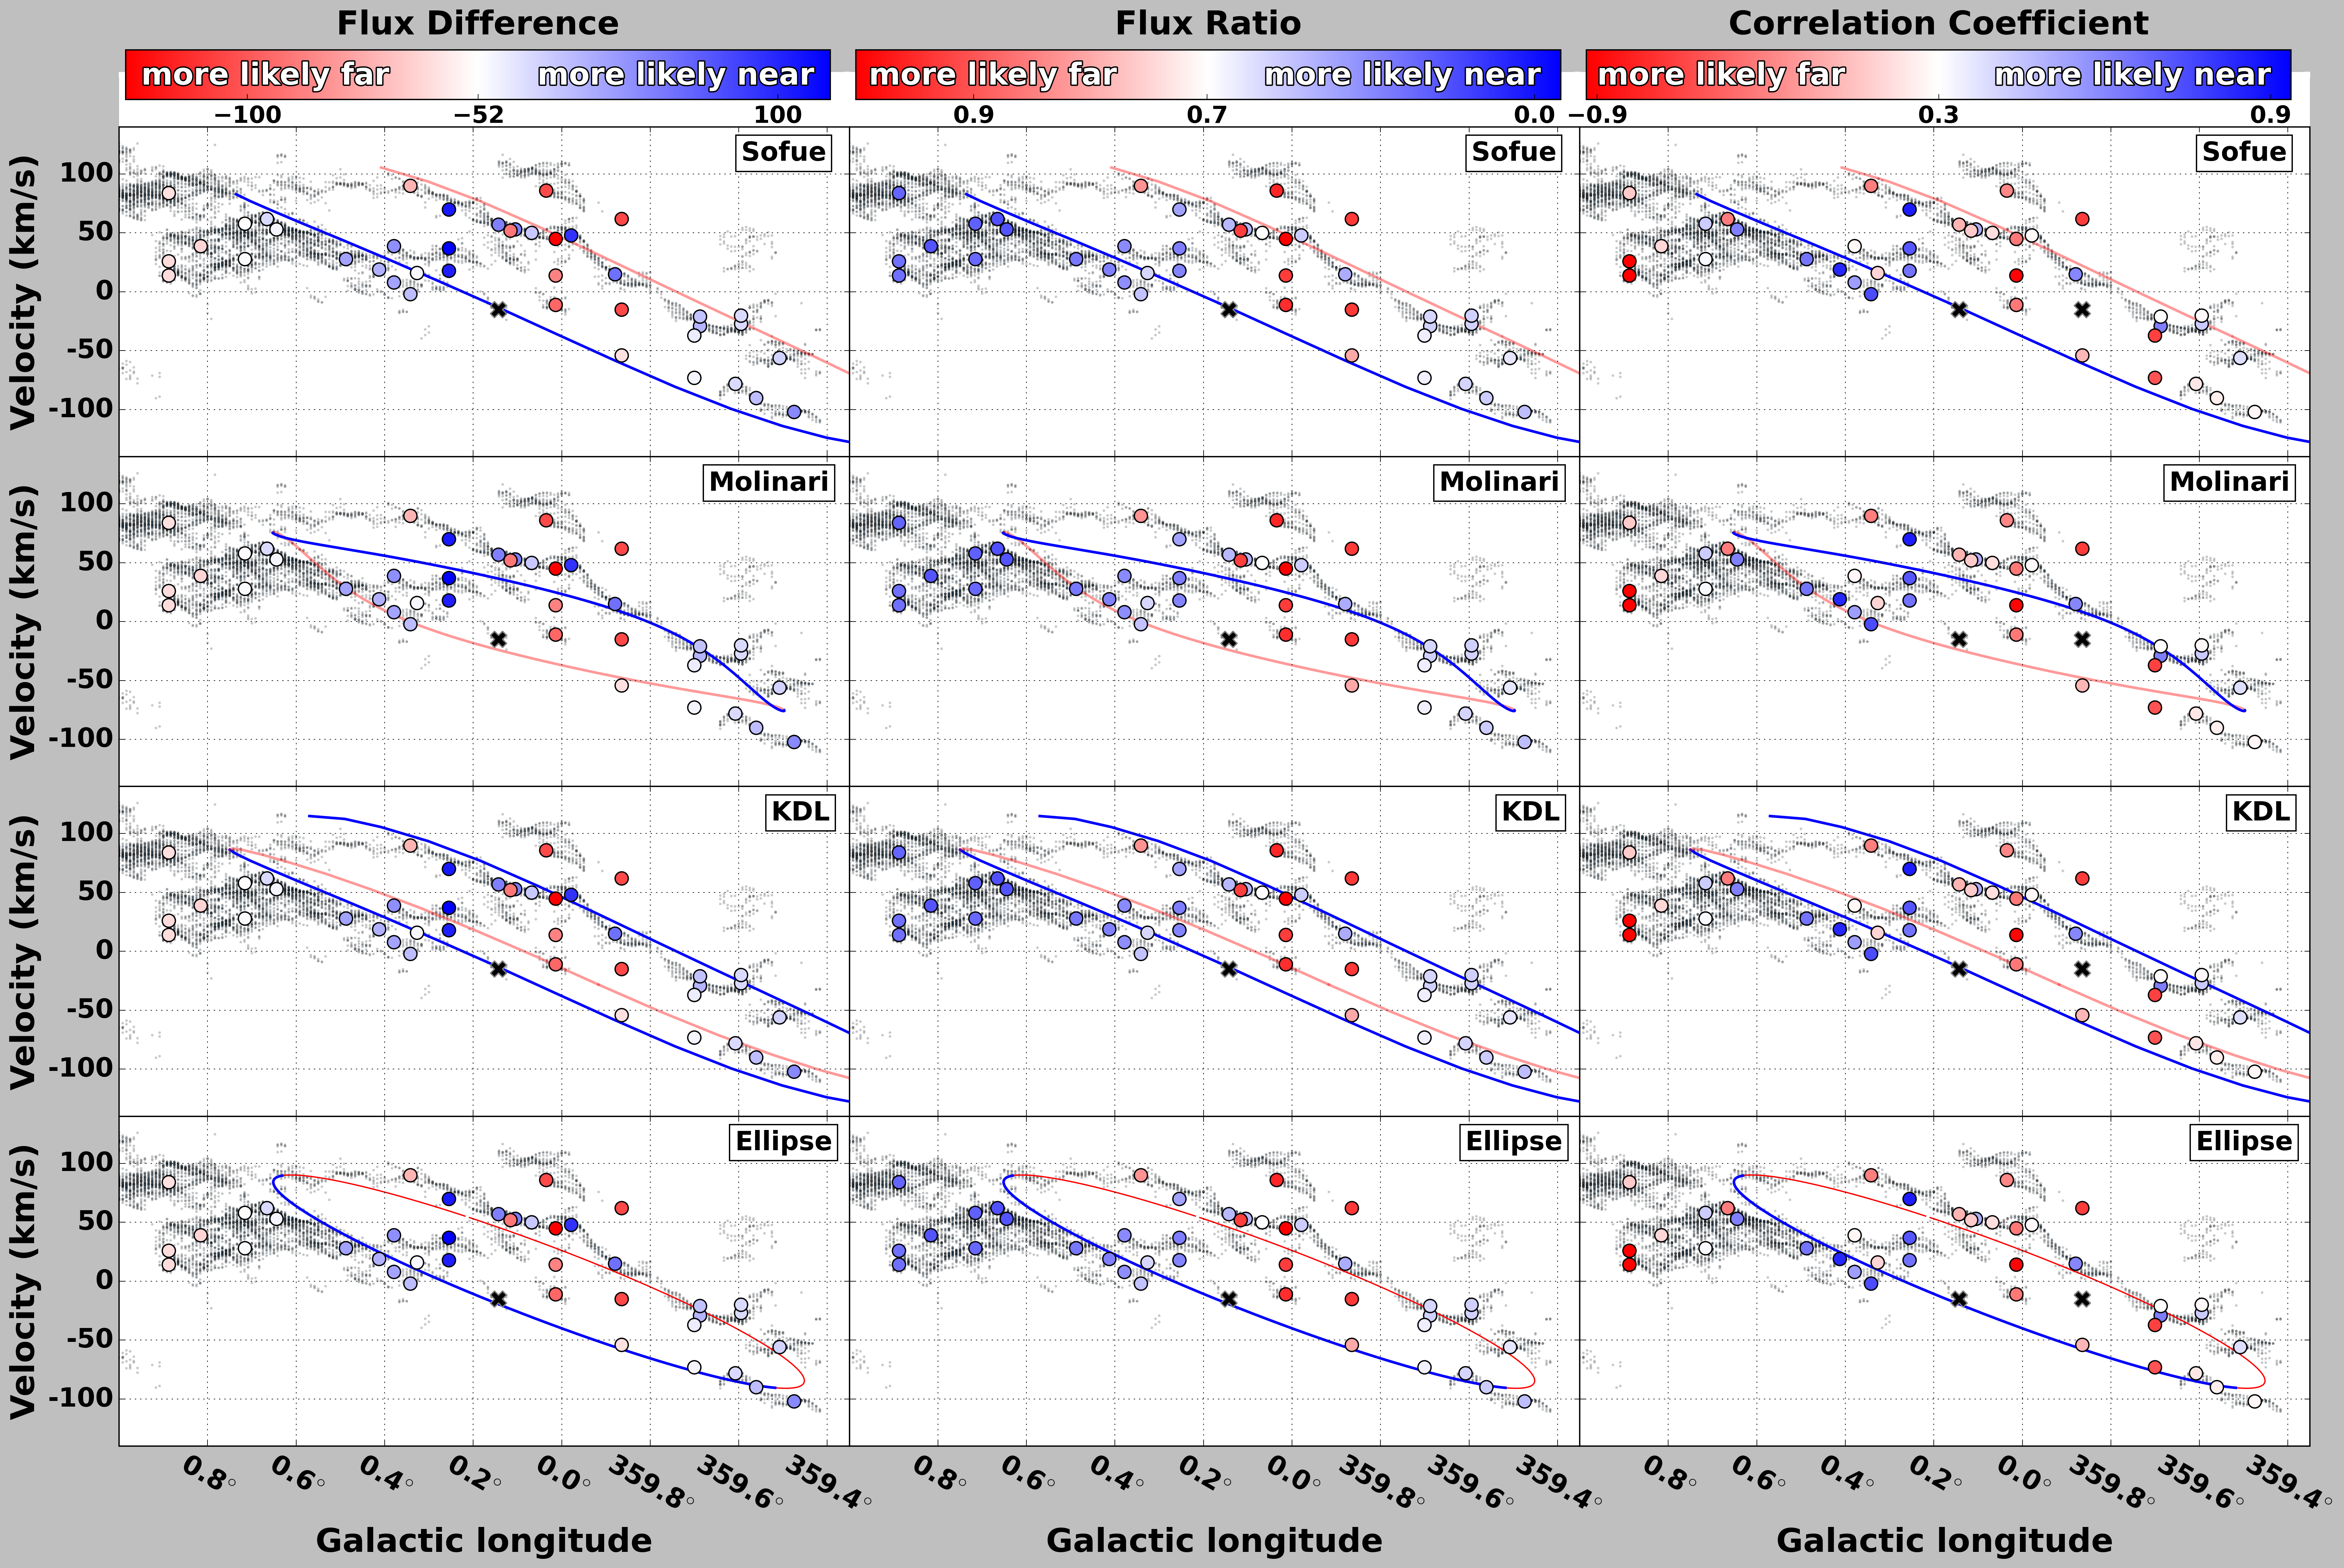

<Figure size 640x480 with 0 Axes>

In [52]:
scouse_fits = pd.read_csv('final_cmz_scouse_hnco_fits.csv',
              usecols=[0,1,2,3,5,7], names=['n', 'l', 'b', 'amp', 'velocity', 'FWHM'],
              sep="\s+")

cat = Table.read('CMZ_cloud_catalogue_data.tex')

corr_coeff_use = cat['r_p_max']
absorp_tab = Table.read('absorption_comparison_table.tex')
absorp_value = absorp_tab['fraction_value']
absorp_13co = absorp_tab['co_h2co_ratio']
absorp_index = absorp_tab['leaf_id']


l   = scouse_fits['l'].values
b   = scouse_fits['b'].values
v   = scouse_fits['velocity'].values
amp = scouse_fits['amp'].values


fxsz = 25
xyrat = 2./3.
fysz = fxsz * xyrat
ds = 0.05
fig = plt.figure( figsize=(fxsz,fysz), dpi=300)
gs = GridSpec(26,9)
gs.update(left=ds, right=1-0.025, bottom=0.085, top=1-0.01, hspace=0, wspace=0)

#Colorbars
axes1 = plt.subplot(gs[1, :3])
axes2 = plt.subplot(gs[1,3:6])
axes3 = plt.subplot(gs[1,6:9])


axes4 = plt.subplot(gs[2:8,:3])
axes5 = plt.subplot(gs[8:14,:3])
axes6 = plt.subplot(gs[14:20,:3])
axes7 = plt.subplot(gs[20:26,:3])

axes8 = plt.subplot(gs[2:8,3:6])
axes9 = plt.subplot(gs[8:14,3:6])
axes10 = plt.subplot(gs[14:20,3:6])
axes11 = plt.subplot(gs[20:26,3:6])

axes12 = plt.subplot(gs[2:8,6:9])
axes13 = plt.subplot(gs[8:14,6:9])
axes14 = plt.subplot(gs[14:20,6:9])
axes15 = plt.subplot(gs[20:26,6:9])


###FLUX DIFF POINTS###


for j in [axes4,axes5,axes6,axes7]:
    divnorm = mc.TwoSlopeNorm(vmin=np.nanmin(cat['flux_diff_max']), vcenter=-52.09, vmax=np.nanmax(cat['flux_diff_max']))
    j.scatter(l, v, c=amp, cmap='Blues', marker='o', s=1, facecolor='1',
                    norm=mpl.colors.LogNorm(), alpha=0.2, zorder=1)
    for i in range(0,len(cat)):
        if np.isnan(cat['flux_diff_max'][i])==False:
            sc1 = j.scatter(cat['l'][i], cat['v'][i], marker='o', s=100, edgecolor='k', zorder=3, c=cat['flux_diff_max'][i], cmap='bwr_r', norm=divnorm)
        else:
            j.scatter(cat['l'][i], cat['v'][i], marker='X', s=150, edgecolor='gray', zorder=3, c='k')     

    j.grid(True)
    j.set_xlim(1.,-0.65)
    j.set_ylim(-140,140)
    j.set_rasterized(True)
    j.yaxis.set_ticklabels([" ", -100,-50,0,50,100, " "],fontsize=20)
    j.set_ylabel('Velocity (km/s)',fontsize=25)


    

##FLUX RATIO POINTS###
flux_ratio_center = 0.699
for j in [axes8,axes9,axes10,axes11]:
    j.scatter(l, v, c=amp, cmap='Blues', marker='o', s=1, facecolor='1',
                    norm=mpl.colors.LogNorm(), alpha=0.2, zorder=1)
    for i in range(0,len(cat)):
        divnorm = mc.TwoSlopeNorm(vmin=np.nanmin(cat['flux_ratio_max']), vcenter=flux_ratio_center, vmax=np.nanmax(cat['flux_ratio_max']))
        if np.isnan(cat['flux_ratio_max'][i])==False:
            sc2 = j.scatter(cat['l'][i], cat['v'][i], marker='o', s=100, edgecolor='k', zorder=3, c=cat['flux_ratio_max'][i], cmap='bwr', norm=divnorm)
        else:
            j.scatter(cat['l'][i], cat['v'][i], marker='X', s=150, edgecolor='gray', zorder=3, c='k')     


    j.grid(True)
    j.set_xlim(1.,-0.65)
    j.set_ylim(-140,140)
    j.set_rasterized(True)   
    j.yaxis.set_ticklabels([])

##CORR COEFF POINTS###
for j in [axes12,axes13,axes14,axes15]:
    j.scatter(l, v, c=amp, cmap='Blues', marker='o', s=1, facecolor='1',
                    norm=mpl.colors.LogNorm(), alpha=0.2, zorder=1)
    for i in range(0,len(cat)):
        divnorm = mc.TwoSlopeNorm(vmin=np.nanmin(corr_coeff_use), vcenter=0.3, vmax=np.nanmax(corr_coeff_use))
        if np.isnan(corr_coeff_use[i]) == False:
            sc3 = j.scatter(cat['l'][i], cat['v'][i], marker='o', s=100, edgecolor='k', zorder=3, c=corr_coeff_use[i], cmap='bwr_r', norm=divnorm)
        else:
            j.scatter(cat['l'][i], cat['v'][i], marker='X', s=150, edgecolor='gray', zorder=3, c='k')     

    j.grid(True)
    j.set_xlim(1.,-0.65)
    j.set_ylim(-140,140)
    j.set_rasterized(True)   
    j.yaxis.set_ticklabels([])
    
    
###ORBITAL MODELS###

"""
#Sofue
"""
for ax in [axes4, axes8, axes12]:
    sofue1 = np.loadtxt('sofue_lbv_arm1.txt', unpack=True)
    sofue1_l, sofue1_b, sofue1_v = sofue1[0], sofue1[1], sofue1[2]
    ax.plot(sofue1_l, sofue1_v, ls='-', color='blue', linewidth=2, zorder=2)

    sofue2 = np.loadtxt('sofue_lbv_arm2.txt', unpack=True)
    sofue2_l, sofue2_b, sofue2_v = sofue2[0], sofue2[1], sofue2[2]
    ax.plot(sofue2_l, sofue2_v, ls='-', color='red', linewidth=2, zorder=2, alpha=0.4)
    ax.xaxis.set_ticklabels([])
    #ax[0].yaxis.set_ticklabels([-.30," " , -0.20," " , -.10," " , 0.00," " , " "])
    ax.text(0.91, 0.92,'Sofue', ha='center', va='center', transform=ax.transAxes,
               bbox=dict(facecolor='white', edgecolor='k', alpha=1),fontsize=20)
    #ax[0].set_ylabel('Velocity (km/s)')
    
"""
#Molinari
"""
for ax in [axes5, axes9, axes13]:

    ml = np.loadtxt('molinari_lbvlos.txt', unpack=True)
    lk, bk, vk = ml[0], ml[1], ml[2]
    ax.plot(-1*lk[80:580], vk[80:580], ls='-', color='red', linewidth=2, zorder=2, alpha=0.4)
    ax.plot(-1*lk[0:80], vk[0:80], ls='-', color='blue', linewidth=2, zorder=2)
    ax.plot(-1*lk[581:], vk[581:], ls='-', color='blue', linewidth=2, zorder=2)
    ax.text(0.89, 0.92,'Molinari', ha='center', va='center', transform=ax.transAxes,
               bbox=dict(facecolor='white', edgecolor='k', alpha=1), fontsize=20)

    ax.xaxis.set_ticklabels([])
    #ax[1].yaxis.set_ticklabels([-.30," " , -0.20," " , -.10," " , 0.00," " , " "])
    #ax[1].set_ylabel('Velocity (km/s)')

"""
#KDL
"""   
for ax in [axes6, axes10, axes14]:
    
    kdl = np.loadtxt('kdl_lbv.txt', unpack=True)
    lk, bk, vk = kdl[0], kdl[1], kdl[2]
    ax.plot(lk[0:16], vk[0:16], ls='-', color='blue', linewidth=2, zorder=2)
    ax.plot(lk[15:26], vk[15:26], ls='-', color='red', linewidth=2, zorder=2, alpha=0.4)
    ax.plot(lk[25:36], vk[25:36], ls='-', color='red', linewidth=2, zorder=2, alpha=0.4)
    ax.plot(lk[35:51], vk[35:51], ls='-', color='blue', linewidth=2, zorder=2)
    ax.xaxis.set_ticklabels([])
    #ax[2].yaxis.set_ticklabels([-.30," " , -0.20," " , -.10," " , 0.00," " , " "])

    ax.text(0.933, 0.92,'KDL', ha='center', va='center', transform=ax.transAxes,
               bbox=dict(facecolor='white', edgecolor='k', alpha=1), fontsize=20)

"""
#Rings
"""
for ax in [axes7,axes11,axes15]:

    ax.plot(np.degrees(Rings.l[back_ind[0:-1]]),Rings.vr[back_ind[0:-1]],c='red')
    ax.plot(np.degrees(Rings.l[fore_ind[0:]]),Rings.vr[fore_ind[0:]],c='blue', linewidth=2, zorder=2)
    
    plt.draw()
    labels = ax.get_xticklabels()
    labels[0] = labels[-1] = " "
    ax.set_xticklabels(labels, fontsize=20, rotation=-30)
    
    ax.text(0.91, 0.92,'Ellipse', ha='center', va='center', transform=ax.transAxes,
           bbox=dict(facecolor='white', edgecolor='k', alpha=1),fontsize=20)
    ax.set_xlabel('Galactic longitude', fontsize=25)
    
    ax.xaxis.set_ticklabels([r'',r'359.4$^{\circ}$',r'359.6$^{\circ}$',r'359.8$^{\circ}$',r'0.0$^{\circ}$',r'0.2$^{\circ}$',
                           r'0.4$^{\circ}$',r'0.6$^{\circ}$',r'0.8$^{\circ}$',])



cax_points1 = [0.009,0.50,0.965,0.90]
cax_points2 = [0.009,0.50,0.965,0.90]
cax_points3 = [0.009,0.50,0.965,0.90]
cax1 = axes1.inset_axes(cax_points1)
cax2 = axes2.inset_axes(cax_points2)
cax3 = axes3.inset_axes(cax_points3)
cb1 = fig.colorbar(ax = axes1, mappable = sc1, cax = cax1, orientation = 'horizontal', ticks=[-100, -52, 100])
cb2 = fig.colorbar(ax = axes2, mappable = sc2, cax = cax2, orientation = 'horizontal', ticks=[0, 0.7, 0.9])
cb3 = fig.colorbar(ax = axes3, mappable = sc3, cax = cax3, orientation = 'horizontal', ticks=[-0.9, 0.3, 0.9])





for spine in axes1.spines.values():
    spine.set_visible(False)
for spine in axes2.spines.values():
    spine.set_visible(False)
for spine in axes3.spines.values():
    spine.set_visible(False)
    
for ax in [axes1,axes2,axes3]:
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(axis='both',which='both',bottom=False,left=False, color='white')
    
cb1.set_label(r'Flux Difference',loc='center',labelpad=-90, fontsize=25)
cb2.set_label(r'Flux Ratio',loc='center',labelpad=-90, fontsize=25)
cb3.set_label(r'Correlation Coefficient',loc='center',labelpad=-90, fontsize=25)
cb1.ax.tick_params(labelsize=18)
cb2.ax.tick_params(labelsize=18)
cb3.ax.tick_params(labelsize=18)

cb2.ax.invert_xaxis()

import matplotlib.patheffects as pe
cb1.ax.text(-22, 0.3, r'more likely near', color='white', rotation=0, fontsize=23, weight='bold',path_effects=[pe.withStroke(linewidth=2, foreground="black")])
cb1.ax.text(-122, 0.3 , r'more likely far', color='white', rotation=0, fontsize=23, weight='bold',path_effects=[pe.withStroke(linewidth=2, foreground="black")])

cb2.ax.text(0.58, 0.3, r'more likely near', color='white', rotation=0, fontsize=23, weight='bold',path_effects=[pe.withStroke(linewidth=2, foreground="black")])
cb2.ax.text(0.99, 0.3 , r'more likely far', color='white', rotation=0, fontsize=23, weight='bold',path_effects=[pe.withStroke(linewidth=2, foreground="black")])

cb3.ax.text(0.4, 0.3, r'more likely near', color='white', rotation=0, fontsize=23, weight='bold',path_effects=[pe.withStroke(linewidth=2, foreground="black")])
cb3.ax.text(-0.9, 0.3 , r'more likely far', color='white', rotation=0, fontsize=23, weight='bold',path_effects=[pe.withStroke(linewidth=2, foreground="black")])


plt.savefig('onecol_3d_models_lv_THREE_COMBINED.pdf')
plt.show()


plt.clf()


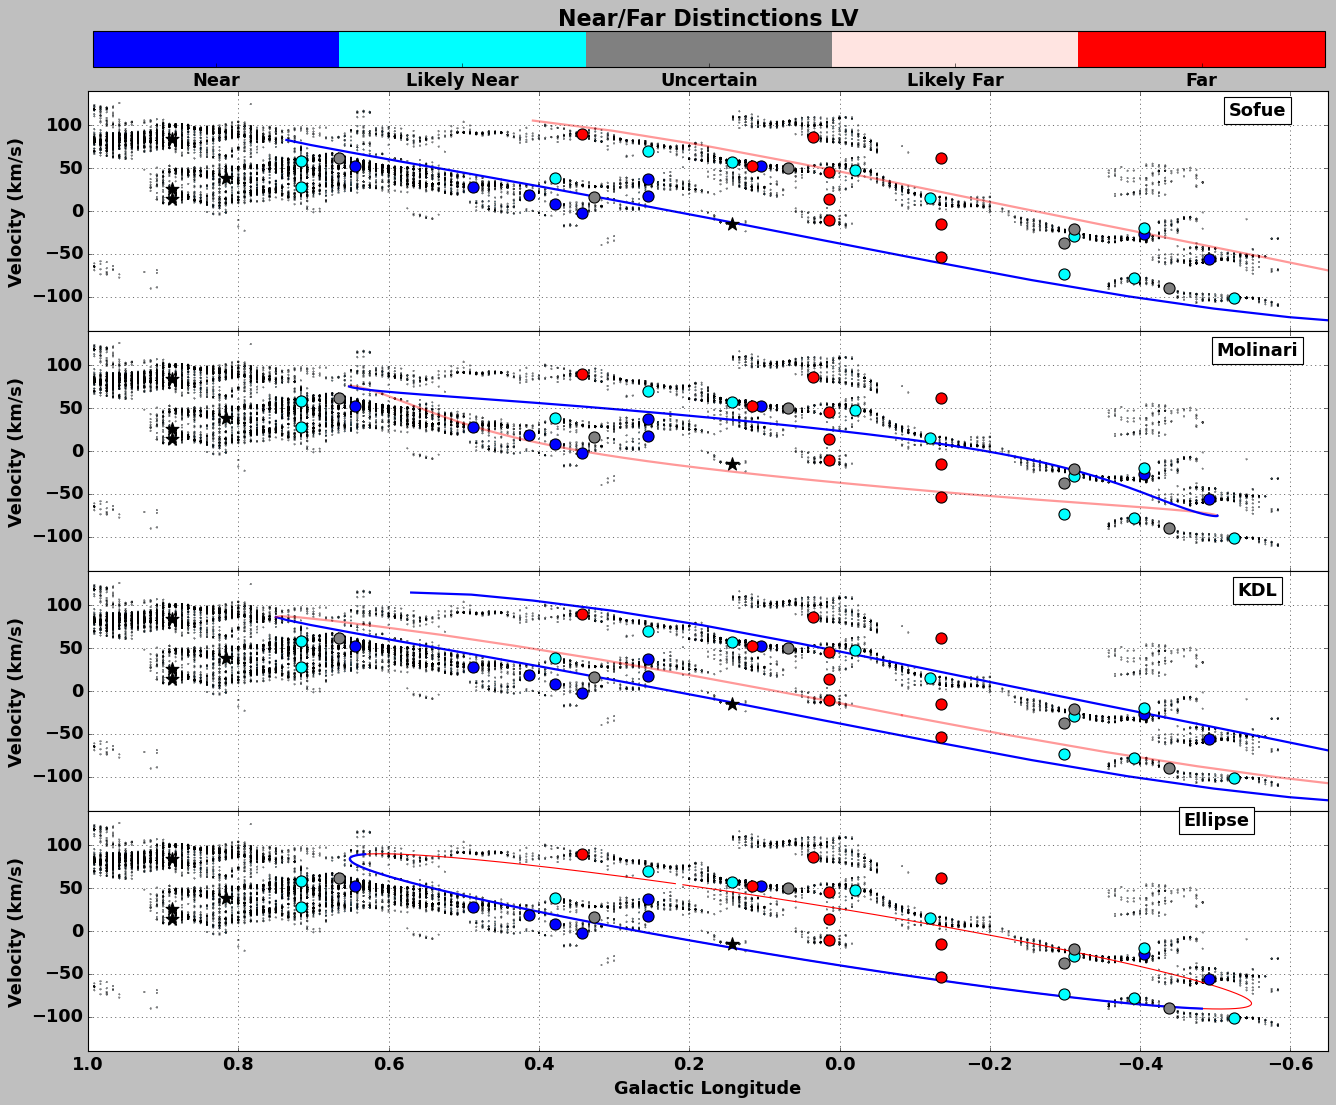

<Figure size 640x480 with 0 Axes>

In [6]:
####SINGLE COLUMN DUST EXTINCTION (RESIZED)####
####NEAR FAR DISTINCTION MEGAPLOT###
scouse_fits = pd.read_csv('final_cmz_scouse_hnco_fits.csv',
              usecols=[0,1,2,3,5,7], names=['n', 'l', 'b', 'amp', 'velocity', 'FWHM'],
              sep="\s+")

NFU = cat['NF_decision']

color_list = ['blue', 'cyan', 'gray' ,'mistyrose', 'red']
cmap = (mpl.colors.ListedColormap(color_list))

l   = scouse_fits['l'].values
b   = scouse_fits['b'].values
v   = scouse_fits['velocity'].values
amp = scouse_fits['amp'].values



fig, ax = plt.subplots(nrows=4, ncols=1,  figsize=(20,15))
plt.subplots_adjust(wspace=0, hspace=0)


for row in ax:
    for i in range(0,len(cat)):
        row.scatter(l, v, c=amp, cmap='Blues', marker='o', s=1, facecolor='1',
                    norm=mpl.colors.LogNorm(), alpha=0.01, zorder=1)
        if cat['NF_decision'][i] == 'N':
            sc = row.scatter(cat['l'][i], cat['v'][i], marker='o', s=100, edgecolor='k', zorder=3, c=color_list[0],  norm=divnorm)
            
        if cat['NF_decision'][i] == 'LN':
            sc = row.scatter(cat['l'][i], cat['v'][i], marker='o', s=100, edgecolor='k', zorder=3, c=color_list[1],  norm=divnorm)            
            
        if cat['NF_decision'][i] == 'LF':
            sc = row.scatter(cat['l'][i], cat['v'][i], marker='o', s=100, edgecolor='k', zorder=3, c=color_list[3],  norm=divnorm)
            
        if cat['NF_decision'][i] == 'F':
            sc = row.scatter(cat['l'][i], cat['v'][i], marker='o', s=100, edgecolor='k', zorder=3, c=color_list[4],  norm=divnorm)
            
        if cat['NF_decision'][i] == 'U':
            sc = row.scatter(cat['l'][i], cat['v'][i], marker='o', s=100, edgecolor='k', zorder=3, c=color_list[2],  norm=divnorm)
            
        if cat['NF_decision'][i] == 'nan':
            row.scatter(cat['l'][i], cat['v'][i], marker='*', s=150, edgecolor='k', zorder=3, c='k')       

    row.grid(True)
    row.set_xlim(1,-0.65)
    row.set_ylim(-140,140)
    row.set_rasterized(True)


"""
#Sofue
"""
sofue1 = np.loadtxt('sofue_lbv_arm1.txt', unpack=True)
sofue1_l, sofue1_b, sofue1_v = sofue1[0], sofue1[1], sofue1[2]
ax[0].plot(sofue1_l, sofue1_v, ls='-', color='blue', linewidth=2, zorder=2)

sofue2 = np.loadtxt('sofue_lbv_arm2.txt', unpack=True)
sofue2_l, sofue2_b, sofue2_v = sofue2[0], sofue2[1], sofue2[2]
ax[0].plot(sofue2_l, sofue2_v, ls='-', color='red', linewidth=2, zorder=2, alpha=0.4)
ax[0].xaxis.set_ticklabels([])
#ax[0].yaxis.set_ticklabels([-.30," " , -0.20," " , -.10," " , 0.00," " , " "])
ax[0].text(0.943, 0.92,'Sofue', ha='center', va='center', transform=ax[0].transAxes,
           bbox=dict(facecolor='white', edgecolor='k', alpha=1))
ax[0].set_ylabel('Velocity (km/s)')

"""


#Molinari
"""
ml = np.loadtxt('molinari_lbvlos.txt', unpack=True)
lk, bk, vk = ml[0], ml[1], ml[2]
ax[1].plot(-1*lk[80:580], vk[80:580], ls='-', color='red', linewidth=2, zorder=2, alpha=0.4)
ax[1].plot(-1*lk[0:80], vk[0:80], ls='-', color='blue', linewidth=2, zorder=2)
ax[1].plot(-1*lk[581:], vk[581:], ls='-', color='blue', linewidth=2, zorder=2)
ax[1].text(0.943, 0.92,'Molinari', ha='center', va='center', transform=ax[1].transAxes,
           bbox=dict(facecolor='white', edgecolor='k', alpha=1))

ax[1].xaxis.set_ticklabels([])
#ax[1].yaxis.set_ticklabels([-.30," " , -0.20," " , -.10," " , 0.00," " , " "])
ax[1].set_ylabel('Velocity (km/s)')



"""
#KDL
"""
kdl = np.loadtxt('kdl_lbv.txt', unpack=True)
lk, bk, vk = kdl[0], kdl[1], kdl[2]
ax[2].plot(lk[0:16], vk[0:16], ls='-', color='blue', linewidth=2, zorder=2)
ax[2].plot(lk[15:26], vk[15:26], ls='-', color='red', linewidth=2, zorder=2, alpha=0.4)
ax[2].plot(lk[25:36], vk[25:36], ls='-', color='red', linewidth=2, zorder=2, alpha=0.4)
ax[2].plot(lk[35:51], vk[35:51], ls='-', color='blue', linewidth=2, zorder=2)
ax[2].xaxis.set_ticklabels([])
#ax[2].yaxis.set_ticklabels([-.30," " , -0.20," " , -.10," " , 0.00," " , " "])

ax[2].text(0.943, 0.92,'KDL', ha='center', va='center', transform=ax[2].transAxes,
           bbox=dict(facecolor='white', edgecolor='k', alpha=1))

ax[2].set_ylabel('Velocity (km/s)')


"""
#Rings
"""


ax[3].plot(np.degrees(Rings.l[back_ind[0:-1]]),Rings.vr[back_ind[0:-1]],c='red')
ax[3].plot(np.degrees(Rings.l[fore_ind[0:]]),Rings.vr[fore_ind[0:]],c='blue', linewidth=2, zorder=2)

#ax[3].xaxis.set_ticklabels([])
#ax[3].yaxis.set_ticklabels([])
ax[3].text(0.91, 0.96,'Ellipse', ha='center', va='center', transform=ax[3].transAxes,
           bbox=dict(facecolor='white', edgecolor='k', alpha=1))

ax[3].set_ylabel('Velocity (km/s)')
ax[3].set_xlabel('Galactic Longitude')


cax = fig.add_axes([0.128, .92, 0.77, 0.03])


bounds = [1, 2, 3, 4, 5, 6]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb = fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=cax,
    ticks=[1.5,2.5,3.5,4.5,5.5],
    spacing='proportional',
    orientation='horizontal',
    #label='Discrete intervals, some other units',
)

cb.ax.set_xticklabels(['Near', 'Likely Near', 'Uncertain', 'Likely Far', 'Far'])


#cb = plt.colorbar(sc, ax=ax.ravel().tolist(), orientation='horizontal', cax=cax)
cb.ax.set_title('Near/Far Distinctions LV', size=20, fontweight='bold', fontname='sans-serif')





#plt.savefig('../paper_figs/Figs/onecol_3d_models_lv_ellipse_colorbar_MEGAPLOT.png')
plt.show()


plt.clf()

In [7]:
ellipse_tab = Table.read('./cloud_catalogue_trimmed_lv.csv')
cloud_id = ellipse_tab['_idx']
cloud_major_sigma = ellipse_tab['major_sigma']
cloud_minor_sigma = ellipse_tab['minor_sigma']
cloud_PA =  ellipse_tab['position_angle']
cloud_rad = ellipse_tab['rad']


cloud_vsig = cat['sigma'] 
cat


<Table length=47>
index   cloud_name      l       b      v   sigma   rad   ... I_model_max flux_diff_max flux_ratio_max ext_frac_max lb_pixel_mask NF_decision min_flux_max
 str3     str14      float64 float64 int64 int64 float64 ...   float64      float64       float64       float64        int64         str3      float64   
----- -------------- ------- ------- ----- ----- ------- ... ----------- ------------- -------------- ------------ ------------- ----------- ------------
    1 G359.475-0.044  -0.525  -0.044  -102     6     4.3 ...     317.106        31.669          0.506        0.992             1          LN       82.971
    2 G359.508-0.135  -0.492  -0.135   -56     9     8.7 ...     276.371       -20.608          0.623        0.815             1           N      117.934
    3 G359.561-0.001  -0.439  -0.001   -90     8     2.7 ...      263.15        -6.674          0.551        0.997             1           U      106.365
   4a G359.595-0.223  -0.405  -0.223   -27    13     4.6 ...     232.561       -26.881          0.567        0.947             1           N      100.903
   4b G359.595-0.223  -0.405  -0.223   -20     8     4.6 ...     234.446       -25.555          0.559        0.932             0          LN      100.903
    5 G359.608+0.018  -0.392   0.018   -78     5     2.0 ...     230.972        -26.81          0.575        0.997             1          LN      123.728
   6a G359.688-0.132  -0.312  -0.132   -29     5     5.6 ...     285.681         0.229           0.56        0.995             0          LN      153.898
   6b G359.688-0.132  -0.312  -0.132   -21    12     5.6 ...     259.951        -9.201          0.576        0.993             1           U      151.445
   7a G359.701+0.032  -0.299   0.032   -73    11     2.4 ...     233.126       -44.223          0.655        0.776             1          LN      154.551
   7b G359.701+0.032  -0.299   0.032   -37     5     2.4 ...     255.086       -39.161          0.648        0.783             0           U      155.592
   8a G359.865+0.023  -0.135   0.023   -54     9     2.0 ...     325.378       -61.153          0.802        0.585             1           F      197.792
   8b G359.865+0.023  -0.135   0.023   -15    15     2.0 ...     305.122      -104.092          0.933         0.16             0           F      233.664
   8c G359.865+0.023  -0.135   0.023    62     6     2.0 ...     310.059      -104.551          0.934        0.213             0           F      197.792
    9  G359.88-0.081   -0.12  -0.081    15    12     5.0 ...     315.944        47.584          0.454        0.996             1          LN      126.201
   10 G359.979-0.071  -0.021  -0.071    48    11     2.7 ...     478.218        91.011          0.549        0.918             1          LN       161.22
  ...            ...     ...     ...   ...   ...     ... ...         ...           ...            ...          ...           ...         ...          ...
  21b    G0.379+0.05   0.379    0.05    39     4     1.7 ...      237.09        27.373          0.355          1.0             0          LN       65.207
   22   G0.413+0.048   0.413   0.048    19    11     2.9 ...     190.317         3.323          0.326          1.0             1           N       59.849
   23   G0.488+0.008   0.488   0.008    28    11     4.1 ...     197.491        13.529          0.299        0.999             1           N        49.44
   24    G0.645+0.03   0.645    0.03    53    12     1.4 ...      99.077       -44.921          0.193          1.0             1           N       45.608
   25   G0.666-0.028   0.666  -0.028    62    12     5.8 ...     121.164       -25.644          0.181        0.933             1           U       38.643
  26a    G0.716-0.09   0.716   -0.09    28    15     5.7 ...     106.837       -48.387          0.256        0.953             1          LN        45.35
  26b    G0.716-0.09   0.716   -0.09    58    11     5.7 ...       93.39       -52.731           0.23        0.985             0    

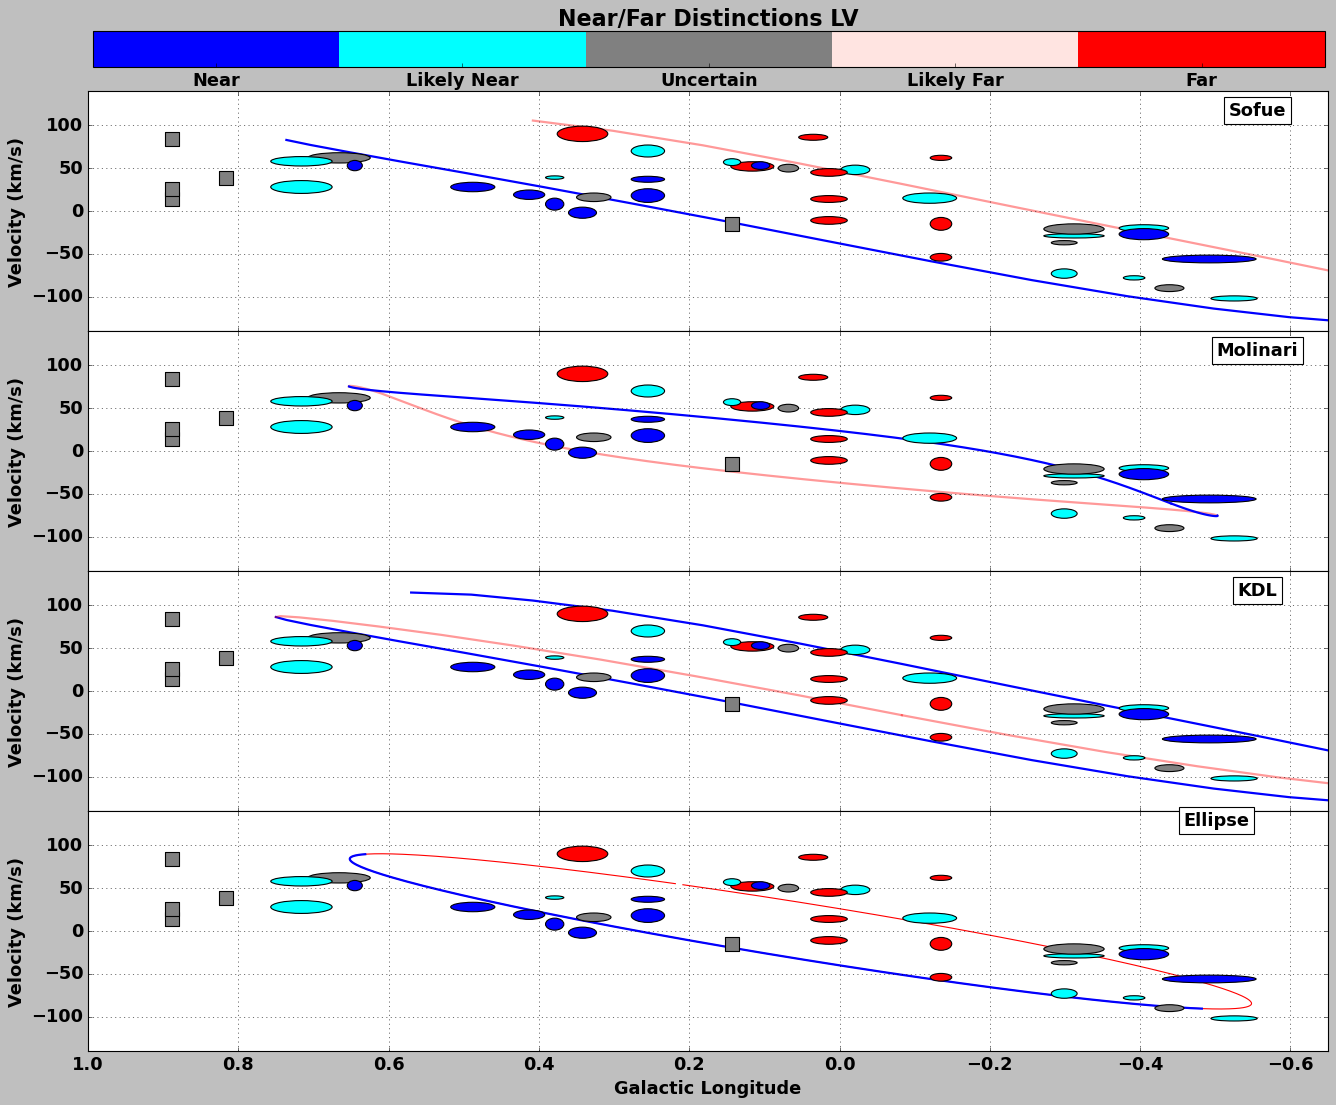

<Figure size 640x480 with 0 Axes>

In [8]:
####SINGLE COLUMN DUST EXTINCTION (RESIZED)####
####NEAR FAR DISTINCTION MEGAPLOT###
scouse_fits = pd.read_csv('final_cmz_scouse_hnco_fits.csv',
              usecols=[0,1,2,3,5,7], names=['n', 'l', 'b', 'amp', 'velocity', 'FWHM'],
              sep="\s+")

NFU = cat['NF_decision']

color_list = ['blue', 'cyan', 'gray' ,'mistyrose', 'red']
cmap = (mpl.colors.ListedColormap(color_list))

l   = scouse_fits['l'].values
b   = scouse_fits['b'].values
v   = scouse_fits['velocity'].values
amp = scouse_fits['amp'].values



fig, ax = plt.subplots(nrows=4, ncols=1,  figsize=(20,15))
plt.subplots_adjust(wspace=0, hspace=0)

for row in ax:
    M = row.transData.get_matrix()
    xscale = M[0,0]
    for i in range(0,len(cat)):

        circle_rad = (cloud_rad[i]/8000) * 57.3 #from parsec to deg
                
        #row.scatter(l, v, c=amp, cmap='Blues', marker='o', s=1, facecolor='1',
        #            norm=mpl.colors.LogNorm(), alpha=0.01, zorder=1)        
        
        #ellipse = mpl.patches.Ellipse((cat['l'][i], cat['v'][i]), cloud_major_sigma[i], cloud_vsig[i])
        ellipse = mpl.patches.Ellipse((cat['l'][i], cat['v'][i]), 2*circle_rad, cloud_vsig[i])
        ellipse.set_zorder(3)
        
        if cat['NF_decision'][i] == 'N':
            row.add_artist(ellipse)
            ellipse.set_facecolor(color_list[0])
            ellipse.set_zorder(10)
            
        if cat['NF_decision'][i] == 'LN':
            row.add_artist(ellipse)
            ellipse.set_facecolor(color_list[1])         
            
        if cat['NF_decision'][i] == 'LF':
            row.add_artist(ellipse)
            ellipse.set_facecolor(color_list[3])
            
        if cat['NF_decision'][i] == 'F':
            row.add_artist(ellipse)
            ellipse.set_facecolor(color_list[4])
            
        if cat['NF_decision'][i] == 'U':
            row.add_artist(ellipse)
            ellipse.set_facecolor(color_list[2])
            
        if cat['NF_decision'][i] == 'nan':
            row.scatter(cat['l'][i], cat['v'][i], marker='s', s=150, edgecolor='k', zorder=3, c='gray')     

    row.grid(True)
    row.set_xlim(1,-0.65)
    row.set_ylim(-140,140)
    row.set_rasterized(True)


"""
#Sofue
"""
sofue1 = np.loadtxt('sofue_lbv_arm1.txt', unpack=True)
sofue1_l, sofue1_b, sofue1_v = sofue1[0], sofue1[1], sofue1[2]
ax[0].plot(sofue1_l, sofue1_v, ls='-', color='blue', linewidth=2, zorder=2)

sofue2 = np.loadtxt('sofue_lbv_arm2.txt', unpack=True)
sofue2_l, sofue2_b, sofue2_v = sofue2[0], sofue2[1], sofue2[2]
ax[0].plot(sofue2_l, sofue2_v, ls='-', color='red', linewidth=2, zorder=2, alpha=0.4)
ax[0].xaxis.set_ticklabels([])
#ax[0].yaxis.set_ticklabels([-.30," " , -0.20," " , -.10," " , 0.00," " , " "])
ax[0].text(0.943, 0.92,'Sofue', ha='center', va='center', transform=ax[0].transAxes,
           bbox=dict(facecolor='white', edgecolor='k', alpha=1))
ax[0].set_ylabel('Velocity (km/s)')

"""


#Molinari
"""
ml = np.loadtxt('molinari_lbvlos.txt', unpack=True)
lk, bk, vk = ml[0], ml[1], ml[2]
ax[1].plot(-1*lk[80:580], vk[80:580], ls='-', color='red', linewidth=2, zorder=2, alpha=0.4)
ax[1].plot(-1*lk[0:80], vk[0:80], ls='-', color='blue', linewidth=2, zorder=2)
ax[1].plot(-1*lk[581:], vk[581:], ls='-', color='blue', linewidth=2, zorder=2)
ax[1].text(0.943, 0.92,'Molinari', ha='center', va='center', transform=ax[1].transAxes,
           bbox=dict(facecolor='white', edgecolor='k', alpha=1))

ax[1].xaxis.set_ticklabels([])
#ax[1].yaxis.set_ticklabels([-.30," " , -0.20," " , -.10," " , 0.00," " , " "])
ax[1].set_ylabel('Velocity (km/s)')



"""
#KDL
"""
kdl = np.loadtxt('kdl_lbv.txt', unpack=True)
lk, bk, vk = kdl[0], kdl[1], kdl[2]
ax[2].plot(lk[0:16], vk[0:16], ls='-', color='blue', linewidth=2, zorder=2)
ax[2].plot(lk[15:26], vk[15:26], ls='-', color='red', linewidth=2, zorder=2, alpha=0.4)
ax[2].plot(lk[25:36], vk[25:36], ls='-', color='red', linewidth=2, zorder=2, alpha=0.4)
ax[2].plot(lk[35:51], vk[35:51], ls='-', color='blue', linewidth=2, zorder=2)
ax[2].xaxis.set_ticklabels([])
#ax[2].yaxis.set_ticklabels([-.30," " , -0.20," " , -.10," " , 0.00," " , " "])

ax[2].text(0.943, 0.92,'KDL', ha='center', va='center', transform=ax[2].transAxes,
           bbox=dict(facecolor='white', edgecolor='k', alpha=1))

ax[2].set_ylabel('Velocity (km/s)')


"""
#Rings
"""
ax[3].plot(np.degrees(Rings.l[back_ind[0:-1]]),Rings.vr[back_ind[0:-1]],c='red')
ax[3].plot(np.degrees(Rings.l[fore_ind[0:]]),Rings.vr[fore_ind[0:]],c='blue', linewidth=2, zorder=2)

#ax[3].xaxis.set_ticklabels([])
#ax[3].yaxis.set_ticklabels([])
ax[3].text(0.91, 0.96,'Ellipse', ha='center', va='center', transform=ax[3].transAxes,
           bbox=dict(facecolor='white', edgecolor='k', alpha=1))

ax[3].set_ylabel('Velocity (km/s)')
ax[3].set_xlabel('Galactic Longitude')


cax = fig.add_axes([0.128, .92, 0.77, 0.03])


bounds = [1, 2, 3, 4, 5, 6]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb = fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=cax,
    ticks=[1.5,2.5,3.5,4.5,5.5],
    spacing='proportional',
    orientation='horizontal',
    #label='Discrete intervals, some other units',
)

cb.ax.set_xticklabels(['Near', 'Likely Near', 'Uncertain', 'Likely Far', 'Far'])


#cb = plt.colorbar(sc, ax=ax.ravel().tolist(), orientation='horizontal', cax=cax)
cb.ax.set_title('Near/Far Distinctions LV', size=20, fontweight='bold', fontname='sans-serif')





#plt.savefig('../paper_figs/Figs/onecol_3d_models_lv_ellipse_colorbar_MEGAPLOT.png', bbox_inches='tight')
plt.show()


plt.clf()

In [9]:
cat['v'][20]

53

/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_18743/1403931693.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].yaxis.set_ticklabels(ylabels, fontsize=20)
/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_18743/1403931693.py:107: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].yaxis.set_ticklabels(ylabels, fontsize=20)
/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_18743/1403931693.py:127: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].yaxis.set_ticklabels(ylabels, fontsize=20)
/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_18743/1403931693.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[3].yaxis.set_ticklabels(ylabels, fontsize=20)
/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_18743/1403931693.py:147: UserWarning: FixedFormatter should only be used together with FixedLocator
  

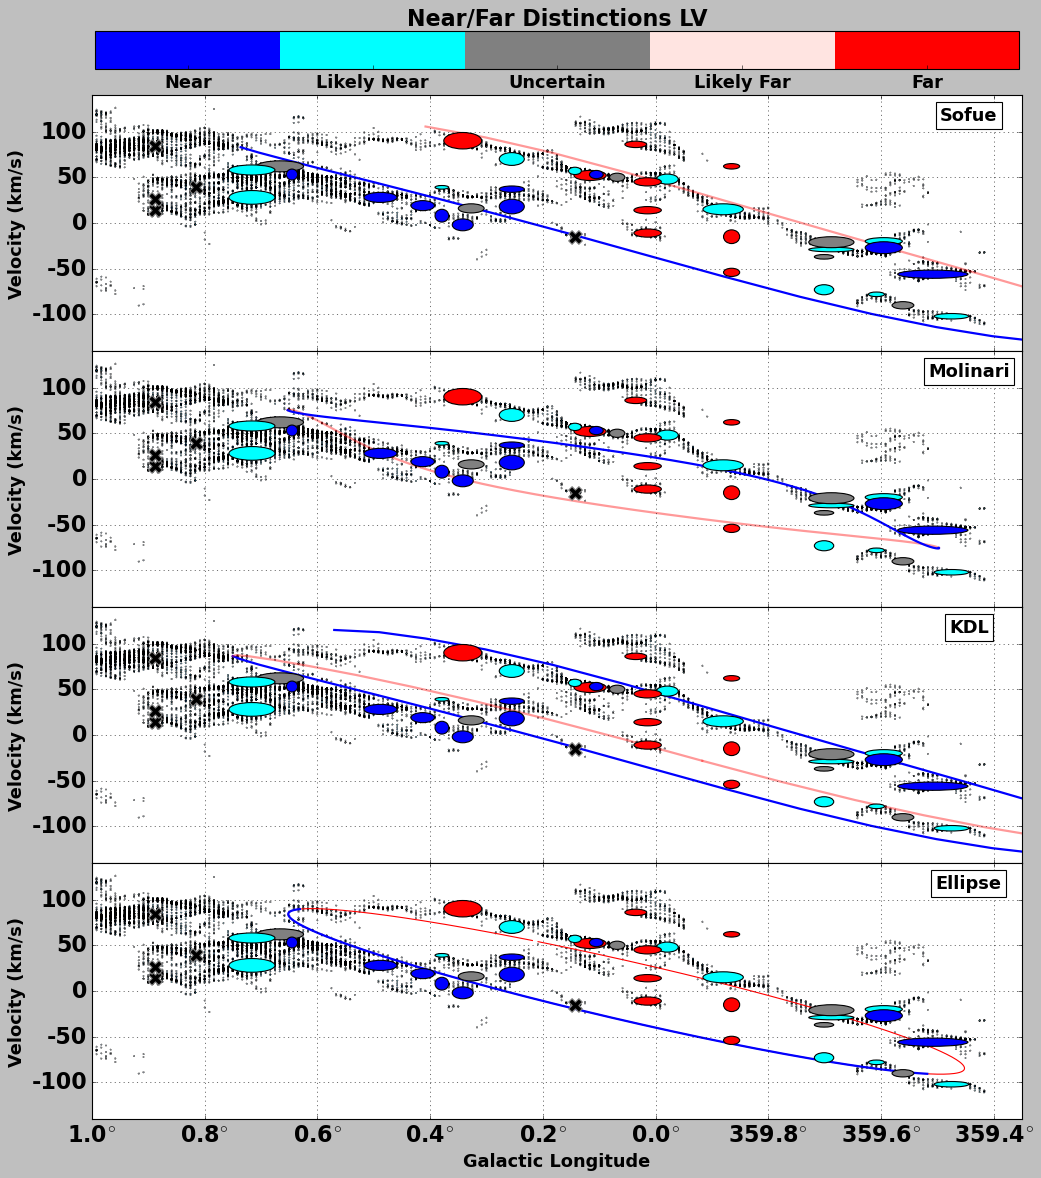

<Figure size 640x480 with 0 Axes>

In [49]:
####SINGLE COLUMN DUST EXTINCTION (RESIZED)####
####NEAR FAR DISTINCTION MEGAPLOT###

from coords import *
from astropy.coordinates import Angle
import astropy.units as u

cat = Table.read('CMZ_cloud_catalogue_data.tex')
scouse_fits = pd.read_csv('final_cmz_scouse_hnco_fits.csv',
              usecols=[0,1,2,3,5,7], names=['n', 'l', 'b', 'amp', 'velocity', 'FWHM'],
              sep="\s+")

NFU = cat['NF_decision']

color_list = ['blue', 'cyan', 'gray' ,'mistyrose', 'red']
cmap = (mpl.colors.ListedColormap(color_list))

l   = scouse_fits['l'].values
b   = scouse_fits['b'].values
v   = scouse_fits['velocity'].values
amp = scouse_fits['amp'].values



fig, ax = plt.subplots(nrows=4, ncols=1,  figsize=(15,16))
plt.subplots_adjust(wspace=0, hspace=0)

for row in ax:
    M = row.transData.get_matrix()
    xscale = M[0,0]
    for i in range(0,len(cat)):

        circle_rad = (cloud_rad[i]/8000) * 57.3 #from parsec to deg
                
        row.scatter(l, v, c=amp, cmap='Blues', marker='o', s=1, facecolor='1',
                    norm=mpl.colors.LogNorm(), alpha=0.01, zorder=1)        
        
        #ellipse = mpl.patches.Ellipse((cat['l'][i], cat['v'][i]), cloud_major_sigma[i], cloud_vsig[i])
        ellipse = mpl.patches.Ellipse((cat['l'][i], cat['v'][i]), 2*circle_rad, cloud_vsig[i])
        ellipse.set_zorder(3)
        
        if cat['NF_decision'][i] == 'N':
            row.add_artist(ellipse)
            ellipse.set_facecolor(color_list[0])
            ellipse.set_zorder(10)
            
        if cat['NF_decision'][i] == 'LN':
            row.add_artist(ellipse)
            ellipse.set_facecolor(color_list[1])         
            
        if cat['NF_decision'][i] == 'LF':
            row.add_artist(ellipse)
            ellipse.set_facecolor(color_list[3])
            
        if cat['NF_decision'][i] == 'F':
            row.add_artist(ellipse)
            ellipse.set_facecolor(color_list[4])
            
        if cat['NF_decision'][i] == 'U':
            row.add_artist(ellipse)
            ellipse.set_facecolor(color_list[2])
            
        if cat['NF_decision'][i] == 'nan':
            row.scatter(cat['l'][i], cat['v'][i], marker='X', s=150, edgecolor='gray', zorder=3, c='k')     

    row.grid(True)
    row.set_xlim(1,-0.65)
    row.set_ylim(-140,140)
    row.set_rasterized(True)


"""
#Sofue
"""
sofue1 = np.loadtxt('sofue_lbv_arm1.txt', unpack=True)
sofue1_l, sofue1_b, sofue1_v = sofue1[0], sofue1[1], sofue1[2]
ax[0].plot(sofue1_l, sofue1_v, ls='-', color='blue', linewidth=2, zorder=2)

sofue2 = np.loadtxt('sofue_lbv_arm2.txt', unpack=True)
sofue2_l, sofue2_b, sofue2_v = sofue2[0], sofue2[1], sofue2[2]
ax[0].plot(sofue2_l, sofue2_v, ls='-', color='red', linewidth=2, zorder=2, alpha=0.4)
ax[0].xaxis.set_ticklabels([])
#ax[0].yaxis.set_ticklabels([-.30," " , -0.20," " , -.10," " , 0.00," " , " "])
ax[0].text(0.943, 0.92,'Sofue', ha='center', va='center', transform=ax[0].transAxes,
           bbox=dict(facecolor='white', edgecolor='k', alpha=1))
ax[0].set_ylabel('Velocity (km/s)')
ylabels = ['-150','-100','-50','0','50','100','150']
ax[0].yaxis.set_ticklabels(ylabels, fontsize=20)

"""


#Molinari
"""
ml = np.loadtxt('molinari_lbvlos.txt', unpack=True)
lk, bk, vk = ml[0], ml[1], ml[2]
ax[1].plot(-1*lk[80:580], vk[80:580], ls='-', color='red', linewidth=2, zorder=2, alpha=0.4)
ax[1].plot(-1*lk[0:80], vk[0:80], ls='-', color='blue', linewidth=2, zorder=2)
ax[1].plot(-1*lk[581:], vk[581:], ls='-', color='blue', linewidth=2, zorder=2)
ax[1].text(0.943, 0.92,'Molinari', ha='center', va='center', transform=ax[1].transAxes,
           bbox=dict(facecolor='white', edgecolor='k', alpha=1))

ax[1].xaxis.set_ticklabels([])
#ax[1].yaxis.set_ticklabels([-.30," " , -0.20," " , -.10," " , 0.00," " , " "])
ax[1].set_ylabel('Velocity (km/s)')
ylabels = ['-150','-100','-50','0','50','100','150']
ax[1].yaxis.set_ticklabels(ylabels, fontsize=20)


"""
#KDL
"""
kdl = np.loadtxt('kdl_lbv.txt', unpack=True)
lk, bk, vk = kdl[0], kdl[1], kdl[2]
ax[2].plot(lk[0:16], vk[0:16], ls='-', color='blue', linewidth=2, zorder=2)
ax[2].plot(lk[15:26], vk[15:26], ls='-', color='red', linewidth=2, zorder=2, alpha=0.4)
ax[2].plot(lk[25:36], vk[25:36], ls='-', color='red', linewidth=2, zorder=2, alpha=0.4)
ax[2].plot(lk[35:51], vk[35:51], ls='-', color='blue', linewidth=2, zorder=2)
ax[2].xaxis.set_ticklabels([])
#ax[2].yaxis.set_ticklabels([-.30," " , -0.20," " , -.10," " , 0.00," " , " "])

ax[2].text(0.943, 0.92,'KDL', ha='center', va='center', transform=ax[2].transAxes,
           bbox=dict(facecolor='white', edgecolor='k', alpha=1))

ax[2].set_ylabel('Velocity (km/s)')
ylabels = ['-150','-100','-50','0','50','100','150']
ax[2].yaxis.set_ticklabels(ylabels, fontsize=20)

"""
#Rings
"""
ax[3].plot(np.degrees(Rings.l[back_ind[0:-1]]),Rings.vr[back_ind[0:-1]],c='red')
ax[3].plot(np.degrees(Rings.l[fore_ind[0:]]),Rings.vr[fore_ind[0:]],c='blue', linewidth=2, zorder=2)

#ax[3].xaxis.set_ticklabels([])
#ax[3].yaxis.set_ticklabels([])
ax[3].text(0.943, 0.92,'Ellipse', ha='center', va='center', transform=ax[3].transAxes,
           bbox=dict(facecolor='white', edgecolor='k', alpha=1))

ax[3].set_ylabel('Velocity (km/s)')
ax[3].set_xlabel('Galactic Longitude')

#lon_dms=Angle([-0.6,-0.4,-0.2,0.0,0.2,0.4,0.6,0.8] * u.degree)
#ax[3].xaxis.set_ticklabels(lon_dms)
ylabels = ['-150','-100','-50','0','50','100','150']
ax[3].yaxis.set_ticklabels(ylabels, fontsize=20)
ax[3].xaxis.set_ticklabels([r'359.2$^{\circ}$}',r'359.4$^{\circ}$',r'359.6$^{\circ}$',r'359.8$^{\circ}$',r'0.0$^{\circ}$',r'0.2$^{\circ}$',
                           r'0.4$^{\circ}$',r'0.6$^{\circ}$',r'0.8$^{\circ}$',r'1.0$^{\circ}$'], fontsize=20)


cax = fig.add_axes([0.128, .92, 0.77, 0.03])


bounds = [1, 2, 3, 4, 5, 6]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb = fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=cax,
    ticks=[1.5,2.5,3.5,4.5,5.5],
    spacing='proportional',
    orientation='horizontal',
    #label='Discrete intervals, some other units',
)

cb.ax.set_xticklabels(['Near', 'Likely Near', 'Uncertain', 'Likely Far', 'Far'])


#cb = plt.colorbar(sc, ax=ax.ravel().tolist(), orientation='horizontal', cax=cax)
cb.ax.set_title('Near/Far Distinctions LV', size=20, fontweight='bold', fontname='sans-serif')





plt.savefig('../paper_figs/Figs/onecol_3d_models_lv_ellipse_colorbar_MEGAPLOT.pdf', bbox_inches='tight')
plt.savefig('../paper_figs/Figs/onecol_3d_models_lv_ellipse_colorbar_MEGAPLOT.png', bbox_inches='tight')
plt.show()


plt.clf()

In [11]:
from mpdaf.obj import dms2deg
from mpdaf.obj import dms2deg

[Text(0, -150.0, ''),
 Text(0, -100.0, ''),
 Text(0, -50.0, ''),
 Text(0, 0.0, ''),
 Text(0, 50.0, ''),
 Text(0, 100.0, ''),
 Text(0, 150.0, '')]

# LV WITHOUT ABSORPTION 

In [ ]:
####SINGLE COLUMN DUST EXTINCTION (RESIZED)####
####NEAR FAR DISTINCTION MEGAPLOT###

cat = Table.read('CMZ_cloud_catalogue_data_no_absorp.tex')

scouse_fits = pd.read_csv('final_cmz_scouse_hnco_fits.csv',
              usecols=[0,1,2,3,5,7], names=['n', 'l', 'b', 'amp', 'velocity', 'FWHM'],
              sep="\s+")

NFU = cat['NF_decision']

color_list = ['blue', 'cyan', 'gray' ,'mistyrose', 'red']
cmap = (mpl.colors.ListedColormap(color_list))

l   = scouse_fits['l'].values
b   = scouse_fits['b'].values
v   = scouse_fits['velocity'].values
amp = scouse_fits['amp'].values



fig, ax = plt.subplots(nrows=4, ncols=1,  figsize=(15,16))
plt.subplots_adjust(wspace=0, hspace=0)

for row in ax:
    M = row.transData.get_matrix()
    xscale = M[0,0]
    for i in range(0,len(cat)):

        circle_rad = (cloud_rad[i]/8000) * 57.3 #from parsec to deg
                
        row.scatter(l, v, c=amp, cmap='Blues', marker='o', s=1, facecolor='1',
                    norm=mpl.colors.LogNorm(), alpha=0.01, zorder=1)        
        
        #ellipse = mpl.patches.Ellipse((cat['l'][i], cat['v'][i]), cloud_major_sigma[i], cloud_vsig[i])
        ellipse = mpl.patches.Ellipse((cat['l'][i], cat['v'][i]), 2*circle_rad, cloud_vsig[i])
        ellipse.set_zorder(3)
        
        if cat['NF_decision'][i] == 'N':
            row.add_artist(ellipse)
            ellipse.set_facecolor(color_list[0])
            
        if cat['NF_decision'][i] == 'LN':
            row.add_artist(ellipse)
            ellipse.set_facecolor(color_list[1])         
            
        if cat['NF_decision'][i] == 'LF':
            row.add_artist(ellipse)
            ellipse.set_facecolor(color_list[3])
            
        if cat['NF_decision'][i] == 'F':
            row.add_artist(ellipse)
            ellipse.set_facecolor(color_list[4])
            
        if cat['NF_decision'][i] == 'U':
            row.add_artist(ellipse)
            ellipse.set_facecolor(color_list[2])
            
        if cat['NF_decision'][i] == 'nan':
            row.scatter(cat['l'][i], cat['b'][i], marker='X', s=150, edgecolor='gray', zorder=3, c='k')     

    row.grid(True)
    row.set_xlim(1,-0.65)
    row.set_ylim(-140,140)
    row.set_rasterized(True)


"""
#Sofue
"""
sofue1 = np.loadtxt('sofue_lbv_arm1.txt', unpack=True)
sofue1_l, sofue1_b, sofue1_v = sofue1[0], sofue1[1], sofue1[2]
ax[0].plot(sofue1_l, sofue1_v, ls='-', color='blue', linewidth=2, zorder=2)

sofue2 = np.loadtxt('sofue_lbv_arm2.txt', unpack=True)
sofue2_l, sofue2_b, sofue2_v = sofue2[0], sofue2[1], sofue2[2]
ax[0].plot(sofue2_l, sofue2_v, ls='-', color='red', linewidth=2, zorder=2, alpha=0.4)
ax[0].xaxis.set_ticklabels([])
#ax[0].yaxis.set_ticklabels([-.30," " , -0.20," " , -.10," " , 0.00," " , " "])
ax[0].text(0.943, 0.92,'Sofue', ha='center', va='center', transform=ax[0].transAxes,
           bbox=dict(facecolor='white', edgecolor='k', alpha=1))
ax[0].set_ylabel('Velocity (km/s)')

"""


#Molinari
"""
ml = np.loadtxt('molinari_lbvlos.txt', unpack=True)
lk, bk, vk = ml[0], ml[1], ml[2]
ax[1].plot(-1*lk[80:580], vk[80:580], ls='-', color='red', linewidth=2, zorder=2, alpha=0.4)
ax[1].plot(-1*lk[0:80], vk[0:80], ls='-', color='blue', linewidth=2, zorder=2)
ax[1].plot(-1*lk[581:], vk[581:], ls='-', color='blue', linewidth=2, zorder=2)
ax[1].text(0.943, 0.92,'Molinari', ha='center', va='center', transform=ax[1].transAxes,
           bbox=dict(facecolor='white', edgecolor='k', alpha=1))

ax[1].xaxis.set_ticklabels([])
#ax[1].yaxis.set_ticklabels([-.30," " , -0.20," " , -.10," " , 0.00," " , " "])
ax[1].set_ylabel('Velocity (km/s)')



"""
#KDL
"""
kdl = np.loadtxt('kdl_lbv.txt', unpack=True)
lk, bk, vk = kdl[0], kdl[1], kdl[2]
ax[2].plot(lk[0:16], vk[0:16], ls='-', color='blue', linewidth=2, zorder=2)
ax[2].plot(lk[15:26], vk[15:26], ls='-', color='red', linewidth=2, zorder=2, alpha=0.4)
ax[2].plot(lk[25:36], vk[25:36], ls='-', color='red', linewidth=2, zorder=2, alpha=0.4)
ax[2].plot(lk[35:51], vk[35:51], ls='-', color='blue', linewidth=2, zorder=2)
ax[2].xaxis.set_ticklabels([])
#ax[2].yaxis.set_ticklabels([-.30," " , -0.20," " , -.10," " , 0.00," " , " "])

ax[2].text(0.943, 0.92,'KDL', ha='center', va='center', transform=ax[2].transAxes,
           bbox=dict(facecolor='white', edgecolor='k', alpha=1))

ax[2].set_ylabel('Velocity (km/s)')


"""
#Rings
"""
ax[3].plot(np.degrees(Rings.l[back_ind[0:-1]]),Rings.vr[back_ind[0:-1]],c='red')
ax[3].plot(np.degrees(Rings.l[fore_ind[0:]]),Rings.vr[fore_ind[0:]],c='blue', linewidth=2, zorder=2)

#ax[3].xaxis.set_ticklabels([])
#ax[3].yaxis.set_ticklabels([])
ax[3].text(0.943, 0.92,'Ellipse', ha='center', va='center', transform=ax[3].transAxes,
           bbox=dict(facecolor='white', edgecolor='k', alpha=1))

ax[3].set_ylabel('Velocity (km/s)')
ax[3].set_xlabel('Galactic Longitude')


cax = fig.add_axes([0.128, .92, 0.77, 0.03])


bounds = [1, 2, 3, 4, 5, 6]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb = fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=cax,
    ticks=[1.5,2.5,3.5,4.5,5.5],
    spacing='proportional',
    orientation='horizontal',
    #label='Discrete intervals, some other units',
)

cb.ax.set_xticklabels(['Near', 'Likely Near', 'Uncertain', 'Likely Far', 'Far'])


#cb = plt.colorbar(sc, ax=ax.ravel().tolist(), orientation='horizontal', cax=cax)
cb.ax.set_title('Near/Far Distinctions LV (NO ABSORP)', size=20, fontweight='bold', fontname='sans-serif')





plt.savefig('../paper_figs/Figs/onecol_3d_models_lv_ellipse_colorbar_MEGAPLOT_NO_ABORP.pdf', bbox_inches='tight')
plt.savefig('../paper_figs/Figs/onecol_3d_models_lv_ellipse_colorbar_MEGAPLOT_NO_ABORP.png', bbox_inches='tight')
plt.show()


plt.clf()